In [1]:
import numpy as np
import pickle

from scipy.stats import spearmanr, pearsonr, rankdata
import itertools
from math import comb

import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# load explanations

In [2]:
#load explanations

#lime
method='lime'
model_names = ['logistic', 'gb', 'rf', 'nn', 'nn_logistic']
n=3000

filenames = {m: f'explanations/expl_{method}_{m}_n{n}.pkl' for m in model_names}
attr_lime = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#kernelshap
method='kernelshap'
model_names = ['logistic', 'gb', 'rf', 'nn', 'nn_logistic']

filenames = {m: f'explanations/expl_{method}_{m}.pkl' for m in model_names}
attr_kernelshap = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#vanillagrad
method='vanillagrad'
model_names = ['nn', 'nn_logistic']

filenames = {m: f'explanations/expl_{method}_{m}.pkl' for m in model_names}
attr_vanillagrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#gradient*input
method='gradtinput'
model_names = ['nn', 'nn_logistic']

filenames = {m: f'explanations/expl_{method}_{m}.pkl' for m in model_names}
attr_gradtinput = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#integrated gradients
method='integratedgrad'
model_names = ['nn', 'nn_logistic']
n=1500

filenames = {m: f'explanations/expl_{method}_{m}_n{n}.pkl' for m in model_names}
attr_integratedgrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#smoothgrad
method='smoothgrad'
model_names = ['nn', 'nn_logistic']
n=1500

filenames = {m: f'explanations/expl_{method}_{m}_n{n}.pkl' for m in model_names}
attr_smoothgrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


# calculate metric for one method pair

## rank correlation

In [3]:
#rank correlation

def rankcorr(attrA, attrB):
    '''
    attrA: np.array, n x p
    attrB: np.array, n x p
    '''
    corrs = []
    #rank features (accounting for ties)
    all_feat_ranksA = rankdata(-np.abs(attrA), method='dense', axis=1) #rankdata gives rank1 for smallest # --> we want rank1 for largest # (aka # with largest magnitude)
    all_feat_ranksB = rankdata(-np.abs(attrB), method='dense', axis=1) 
    for row in range(attrA.shape[0]):
        #calculate correlation on ranks (iterate through rows: https://stackoverflow.com/questions/44947030/how-to-get-scipy-stats-spearmanra-b-compute-correlation-only-between-variable)
        rho, _ = pearsonr(all_feat_ranksA[row, :], all_feat_ranksB[row, :]) 
        corrs.append(rho)    
    return np.array(corrs), np.mean(corrs) #return metric's distribution and average




## pairwise comparison agreement

In [4]:
def pairwise_comp(attrA, attrB):
    
    '''
    inputs
    attrA: np.array, n x p
    attrB: np.array, n x p
    
    outputs:
    pairwise_distr: 1D numpy array (dimensions=(n,)) of pairwise comparison agreement for each data point
    pairwise_avg: mean of pairwise_distr
    '''
    
    n_datapoints = attrA.shape[0]
    n_feat = attrA.shape[1]

    #rank of all features --> manually calculate rankings (instead of using 0, 1, ..., k ranking based on argsort output) to account for ties
    all_feat_ranksA = rankdata(-np.abs(attrA), method='dense', axis=1) #rankdata gives rank1 for smallest # --> we want rank1 for largest # (aka # with largest magnitude)
    all_feat_ranksB = rankdata(-np.abs(attrB), method='dense', axis=1) 

    #count # of pairs of features with same relative ranking
    feat_pairs_w_same_rel_rankings = np.zeros(n_datapoints)

    for feat1, feat2 in itertools.combinations_with_replacement(range(n_feat), 2):
        if feat1 != feat2: 
            rel_rankingA = all_feat_ranksA[:, feat1] <= all_feat_ranksA[:, feat2]
            rel_rankingB = all_feat_ranksB[:, feat1] <= all_feat_ranksB[:, feat2]
            feat_pairs_w_same_rel_rankings += rel_rankingA == rel_rankingB

    pairwise_distr = feat_pairs_w_same_rel_rankings/comb(n_feat, 2)
    
    
    return pairwise_distr, np.mean(pairwise_distr)



## 4 agreement metrics

In [5]:
def agreement_fraction(attrA, attrB, k, metric_type=['overlap', 'rank', 'sign', 'ranksign']):
    
    #id of top-k features
    topk_idA = np.argsort(-np.abs(attrA), axis=1)[:, 0:k]
    topk_idB = np.argsort(-np.abs(attrB), axis=1)[:, 0:k]

    #rank of top-k features --> manually calculate rankings (instead of using 0, 1, ..., k ranking based on argsort output) to account for ties
    all_feat_ranksA = rankdata(-np.abs(attrA), method='dense', axis=1) #rankdata gives rank1 for smallest # --> we want rank1 for largest # (aka # with largest magnitude)
    all_feat_ranksB = rankdata(-np.abs(attrB), method='dense', axis=1) 
    topk_ranksA = np.take_along_axis(all_feat_ranksA, topk_idA, axis=1) 
    topk_ranksB = np.take_along_axis(all_feat_ranksB, topk_idB, axis=1)

    #sign of top-k features
    topk_signA = np.take_along_axis(np.sign(attrA), topk_idA, axis=1)  #pos=1; neg=-1
    topk_signB = np.take_along_axis(np.sign(attrB), topk_idB, axis=1)  

    #overlap agreement = (# topk features in common)/k
    if metric_type=='overlap':
        topk_setsA = [set(row) for row in topk_idA]
        topk_setsB = [set(row) for row in topk_idB]
        #check if: same id
        metric_distr = np.array([len(setA.intersection(setB))/k for setA, setB in zip(topk_setsA, topk_setsB)])

    #rank agreement
    elif metric_type=='rank':    
        topk_idA_df = pd.DataFrame(topk_idA).applymap(str) #id
        topk_idB_df = pd.DataFrame(topk_idB).applymap(str)
        topk_ranksA_df = pd.DataFrame(topk_ranksA).applymap(str) #rank (accounting for ties)
        topk_ranksB_df = pd.DataFrame(topk_ranksB).applymap(str)
        #check if: same id + rank
        topk_id_ranksA_df = ('feat' + topk_idA_df) + ('rank' + topk_ranksA_df)
        topk_id_ranksB_df = ('feat' + topk_idB_df) + ('rank' + topk_ranksB_df)
        metric_distr = (topk_id_ranksA_df == topk_id_ranksB_df).sum(axis=1).to_numpy()/k

    #sign agreement
    elif metric_type=='sign':    
        topk_id_signA = np.multiply(topk_idA, topk_signA) #id + sign
        topk_id_signB = np.multiply(topk_idB, topk_signB)
        #check if: same id + sign
        metric_distr = (topk_id_signA == topk_id_signB).sum(axis=1)/k 

    #rank and sign agreement
    elif metric_type=='ranksign':    
        topk_idA_df = pd.DataFrame(topk_idA).applymap(str) #id
        topk_idB_df = pd.DataFrame(topk_idB).applymap(str)
        topk_ranksA_df = pd.DataFrame(topk_ranksA).applymap(str) #rank (accounting for ties)
        topk_ranksB_df = pd.DataFrame(topk_ranksB).applymap(str)
        topk_signA_df = pd.DataFrame(topk_signA).applymap(str) #sign
        topk_signB_df = pd.DataFrame(topk_signB).applymap(str)
        #check if: same id + rank + sign
        topk_id_ranks_signA_df = ('feat' + topk_idA_df) + ('rank' + topk_ranksA_df) + ('sign' + topk_signA_df)
        topk_id_ranks_signB_df = ('feat' + topk_idB_df) + ('rank' + topk_ranksB_df) + ('sign' + topk_signB_df)
        metric_distr = (topk_id_ranks_signA_df == topk_id_ranks_signB_df).sum(axis=1).to_numpy()/k
        
    return metric_distr, np.mean(metric_distr)
    
    

# calculate metrics for all method pairs

In [6]:
def metric_all_methodpairs(expl_methods_names, expl_methods_attrs, k,
                           metric_type=['rankcorr', 'pairwise', 'overlap', 'rank', 'sign', 'ranksign']):
    '''
    inputs
    expl_methods_names: dictionary with string names of explanation methods (keys=method_index, values=method_name_string)
    expl_methods_attrs: dictionary of attributions (keys=method_index, values=attributions for a model)
    
    outputs
    method_pairs_distr: dictionary with distribution of rank correlation for each method pair (keys=method pair, values=1D array of metric values for each datapoint)
    method_pairs_avg: array with average rank correlation for each pair of methods
    '''
    #initiate dict to store distribution of metric for each method pair
    method_pairs_distr = {}
    
    #initiate array to store average of metric for each method pair
    num_expl_methods = len(expl_methods_attrs)
    method_pairs_avg = np.zeros([num_expl_methods, num_expl_methods])
    
    #fill corr_distr and avg_corr_matrix 
    for a, b in itertools.combinations_with_replacement(range(num_expl_methods), 2):
        #print(f'calculating {expl_methods_names[a]} ({a}) and {expl_methods_names[b]} ({b})')
        
        #calculate metric for method pair
        if metric_type=='rankcorr': 
            metric_distr, metric_avg = rankcorr(attrA=expl_methods_attrs[a], attrB=expl_methods_attrs[b])

        elif metric_type=='pairwise':
            metric_distr, metric_avg = pairwise_comp(attrA=expl_methods_attrs[a], attrB=expl_methods_attrs[b])

        elif metric_type in ['overlap', 'rank', 'sign', 'ranksign']: 
            metric_distr, metric_avg = agreement_fraction(attrA=expl_methods_attrs[a], attrB=expl_methods_attrs[b], k=k, metric_type=metric_type)

        #store metric distribution in dictionary
        if a != b:
            method_pairs_distr[f'{expl_methods_names[a]} vs. {expl_methods_names[b]}'] = metric_distr
        
        #store metric average in array
        method_pairs_avg[a, b] = metric_avg
        method_pairs_avg[b, a] = metric_avg
        
    return method_pairs_distr, method_pairs_avg
    

# plotting

In [7]:
#plot boxplots, function
def boxplot_metric_distr(method_pairs_distr, plot_path, metric_type=['rankcorr', 'pairwise', 'overlap', 'rank', 'sign', 'ranksign']):
    '''
    method_pairs_distr: output of metric_all_methodpairs()
    '''
    #boxplot
    fig, axes = plt.subplots(1, 1, figsize=(5.5, 5.5))
    axes.set(ylim=(-1.1, 1.1))
    bp = sns.boxplot(data=list(method_pairs_distr.values()), color='cornflowerblue', ax=axes)
    bp.set_xticklabels(list(method_pairs_distr.keys()), rotation=90)
    
    metric_string = {'rankcorr': 'Rank correlation', 
                     'pairwise': 'Pairwise comparison agreement', 
                     'overlap': 'Overlap agreement', 
                     'rank': 'Rank agreement', 
                     'sign': 'Sign agreement', 
                     'ranksign': 'Signed rank agreement'}
    bp.set(xlabel='Method pair', ylabel=metric_string[metric_type]);
    fig.tight_layout()
    fig.savefig(plot_path, facecolor='white', transparent=False, bbox_inches='tight', dpi=1200)
    
    

In [8]:
def heatmap_metric_avg(method_pairs_avg, plot_path, 
                       metric_type=['rankcorr', 'pairwise', 'overlap', 'rank', 'sign', 'ranksign'],
                       labels=['LIME', 'KernelSHAP', 'Grad', 'Grad*Input', 'IntGrad', 'SmoothGRAD']):
    
    '''
    method_pairs_avg: output of metric_all_methodpairs()
    '''
    
    #mask = np.invert(np.tril(np.ones_like(corr_matrix, dtype=bool))) #mask for upper triangle
    cmap = sns.color_palette('vlag', as_cmap=True) #diverging colormap
    
    #heatmap
    plt.figure(figsize=(15, 7))
    sns.heatmap(method_pairs_avg, cmap=cmap, #mask=mask, 
                vmin=-1, vmax=1, center=0,
                xticklabels=labels, yticklabels=labels, annot=True, fmt='.4f',
                square=True, linewidths=.5, cbar_kws={'shrink': 0.995})
    plt.yticks(rotation=0)
    
    metric_string = {'rankcorr': 'Rank correlation', 
                     'pairwise': 'Pairwise comparison agreement', 
                     'overlap': 'Overlap agreement', 
                     'rank': 'Rank agreement', 
                     'sign': 'Sign agreement', 
                     'ranksign': 'Signed rank agreement'}
    plt.title(metric_string[metric_type])
    
    plt.savefig(plot_path, facecolor='white', transparent=False, dpi=1200)

# wrap all functions

In [9]:
#combine all functions
def metric_analysis(expl_methods_names, expl_methods_attrs, k, model_name, 
                    metric_type=['rankcorr', 'pairwise', 'overlap', 'rank', 'sign', 'ranksign'],
                    labels=['LIME', 'KernelSHAP', 'Grad', 'Grad*Input', 'IntGrad', 'SmoothGRAD']):
    #calculate metric: distribution and average (for all method pairs)
    method_pairs_distr, method_pairs_avg = metric_all_methodpairs(expl_methods_names, expl_methods_attrs, k, metric_type)
    
    #plot boxplots of metric distributions for each method pair
    plot_path=f'{model_name}_{metric_type}_distr.png' if metric_type in ['rankcorr', 'pairwise'] else f'{model_name}_{metric_type}_k{k}_distr.png'
    boxplot_metric_distr(method_pairs_distr, plot_path, metric_type)
    
    #plot heatmap of metric averages for each method pair
    plot_path=f'{model_name}_{metric_type}_avg.png' if metric_type in ['rankcorr', 'pairwise'] else f'{model_name}_{metric_type}_k{k}_avg.png'
    heatmap_metric_avg(method_pairs_avg, plot_path, metric_type, labels)
    
    return method_pairs_distr, method_pairs_avg


# run on model explanations

----------- calculating: nn, rankcorr -----------
----------- calculating: nn, pairwise -----------
----------- calculating: nn, overlap -----------
k=10
k=15
k=20
----------- calculating: nn, rank -----------
k=10
k=15
k=20
----------- calculating: nn, sign -----------
k=10
k=15
k=20


<ipython-input-7-9eb37bbc705d>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 1, figsize=(5.5, 5.5))


----------- calculating: nn, ranksign -----------
k=10
k=15
k=20
----------- calculating: nn_logistic, rankcorr -----------
----------- calculating: nn_logistic, pairwise -----------
----------- calculating: nn_logistic, overlap -----------
k=10
k=15
k=20
----------- calculating: nn_logistic, rank -----------
k=10
k=15
k=20
----------- calculating: nn_logistic, sign -----------
k=10
k=15
k=20
----------- calculating: nn_logistic, ranksign -----------
k=10
k=15
k=20


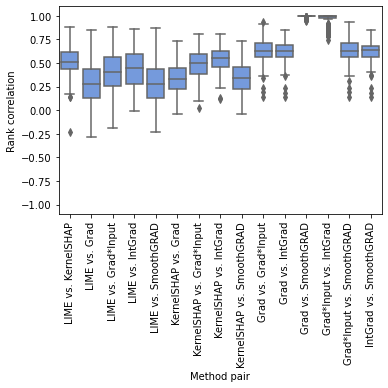

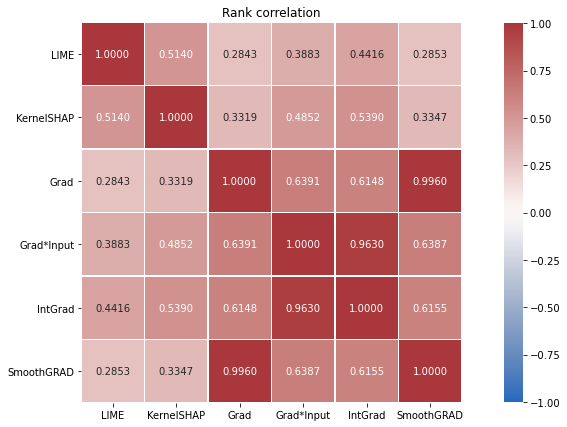

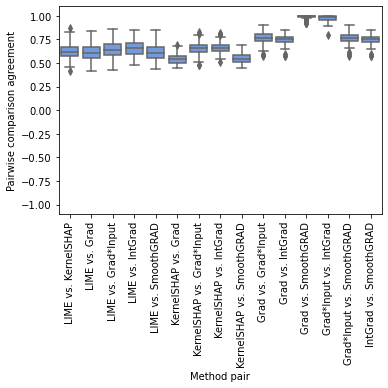

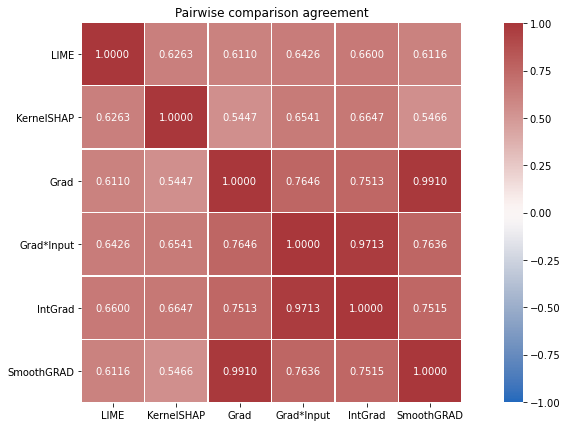

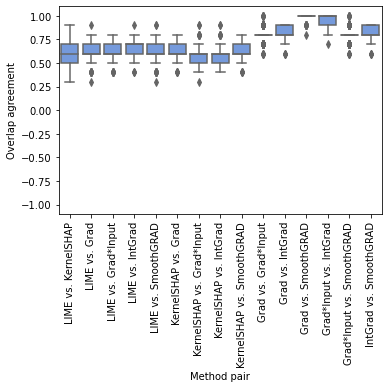

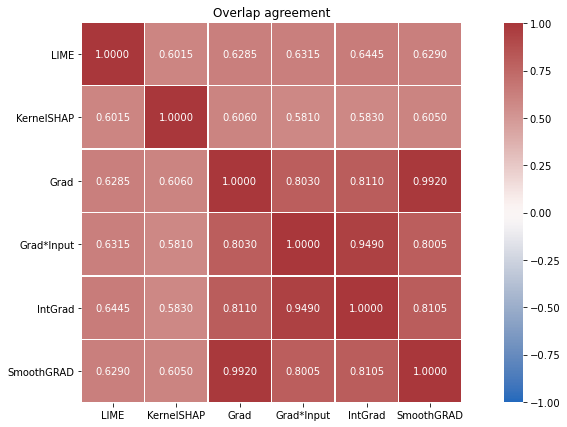

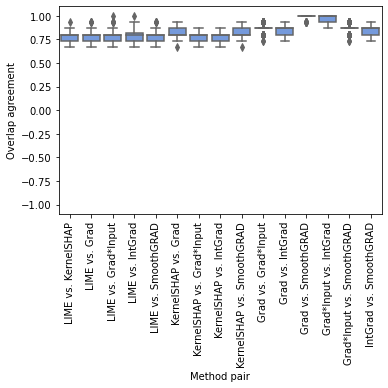

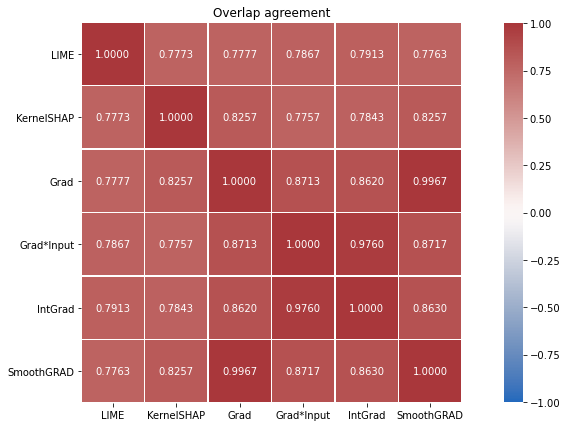

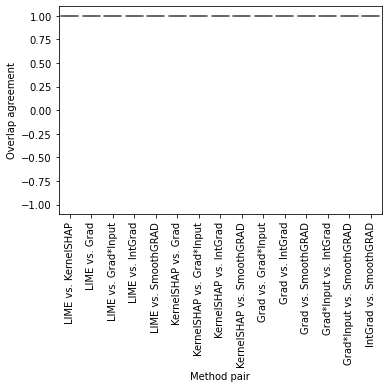

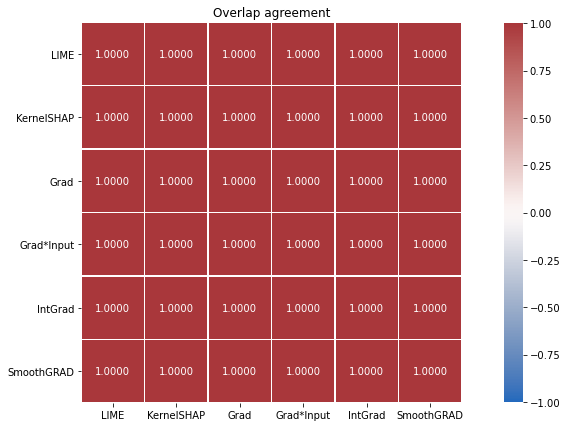

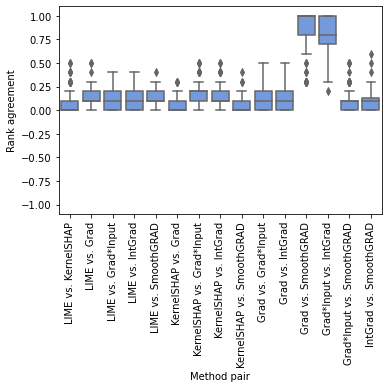

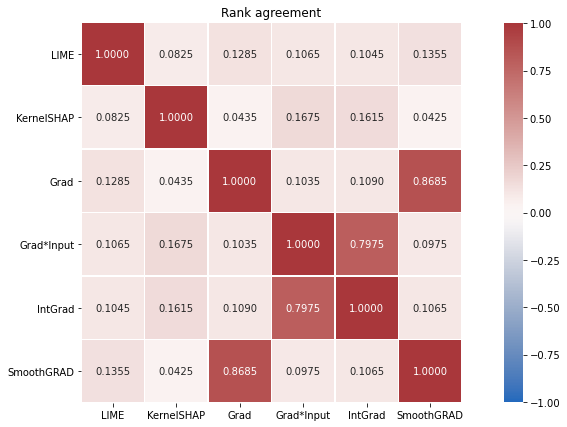

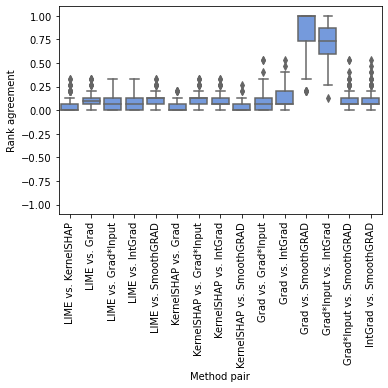

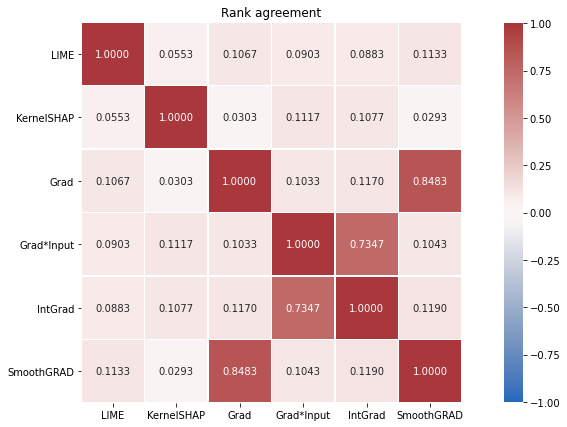

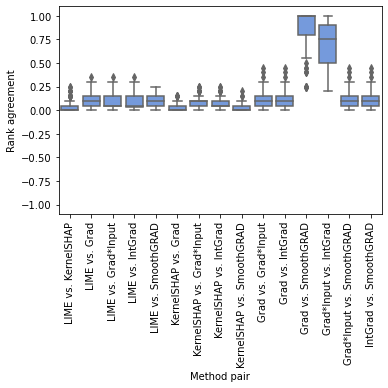

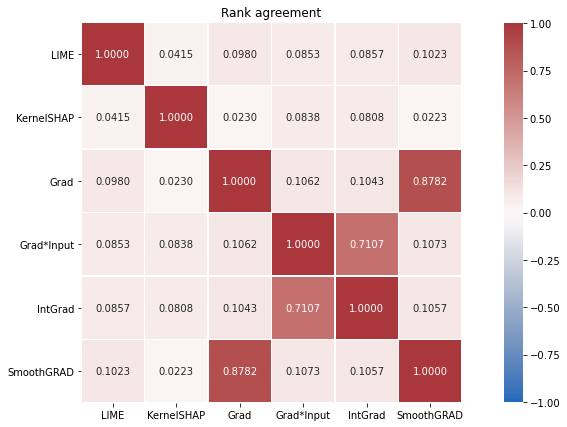

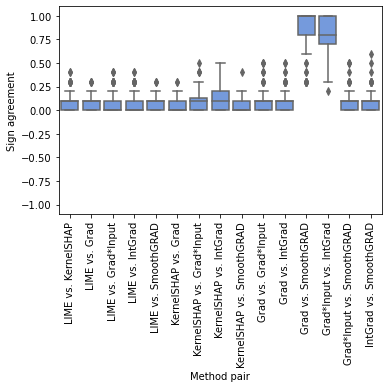

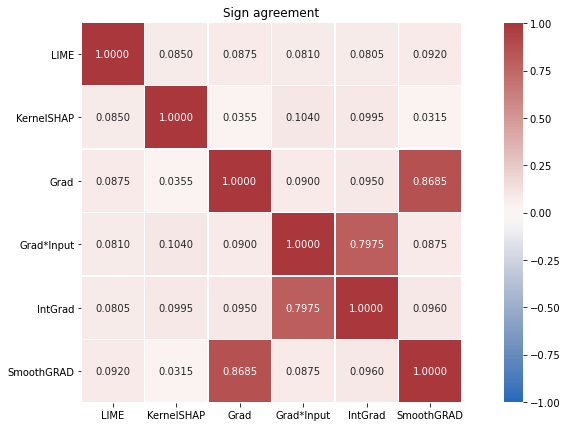

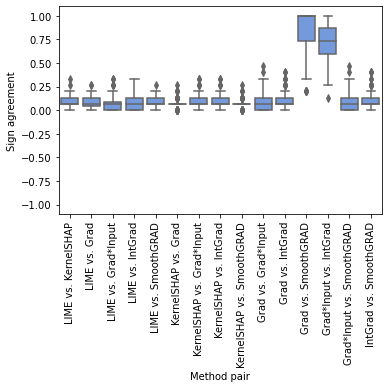

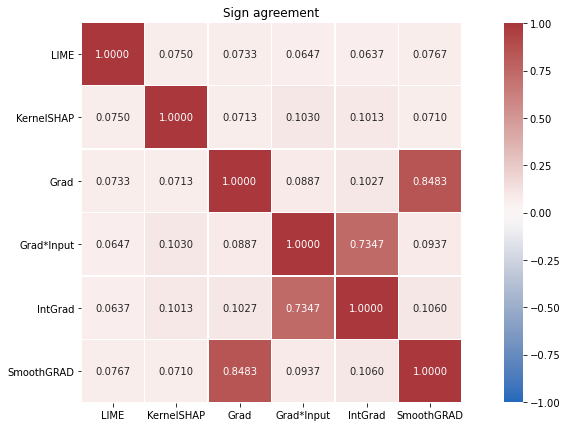

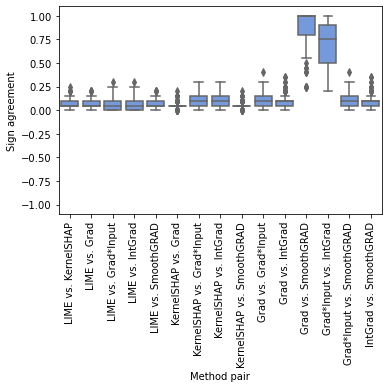

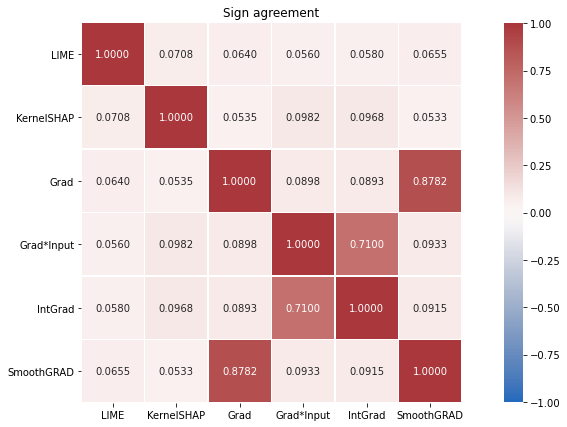

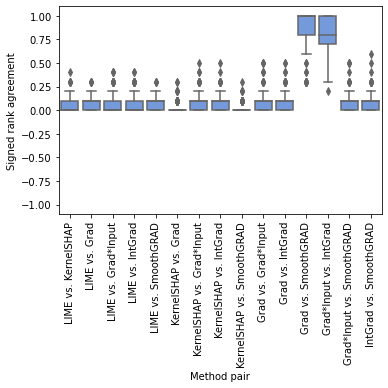

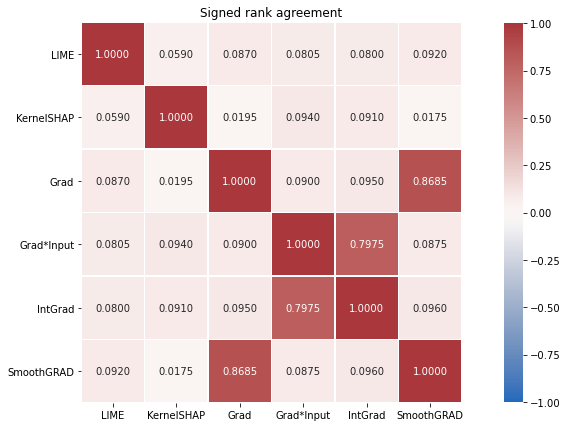

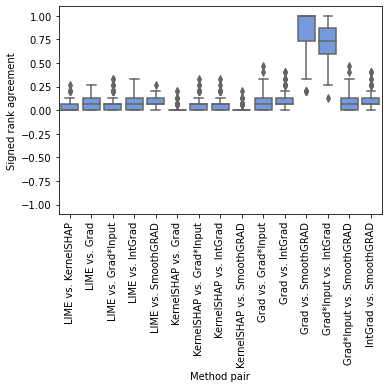

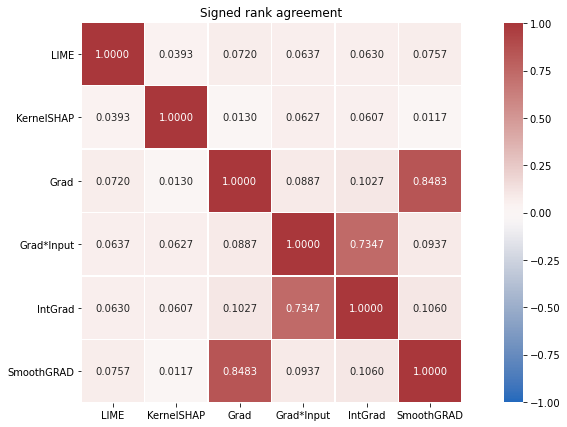

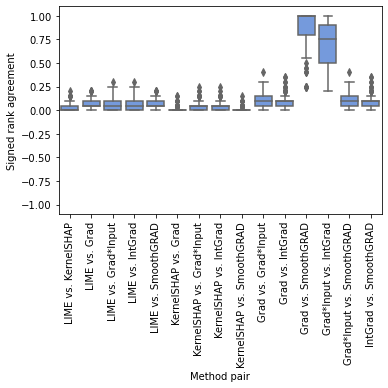

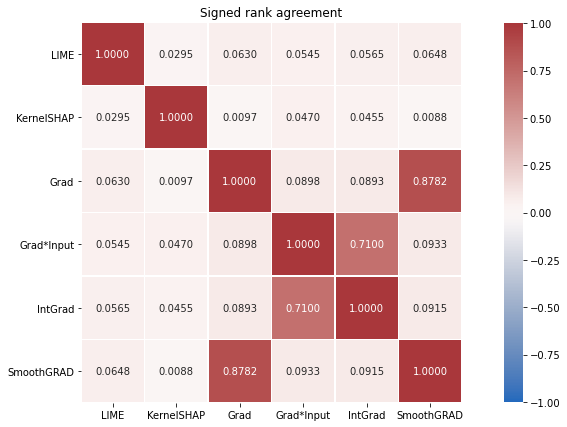

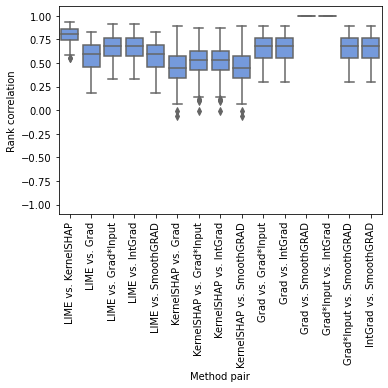

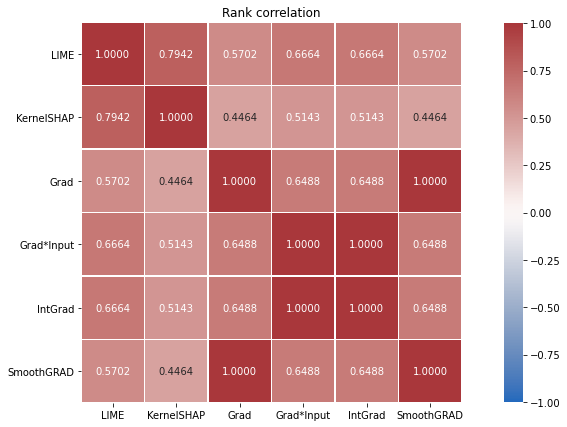

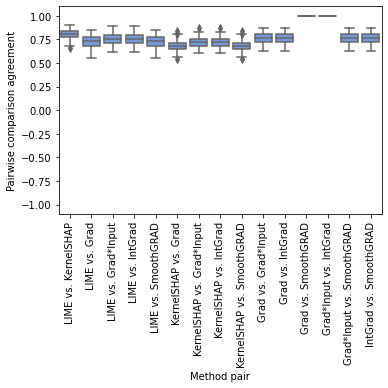

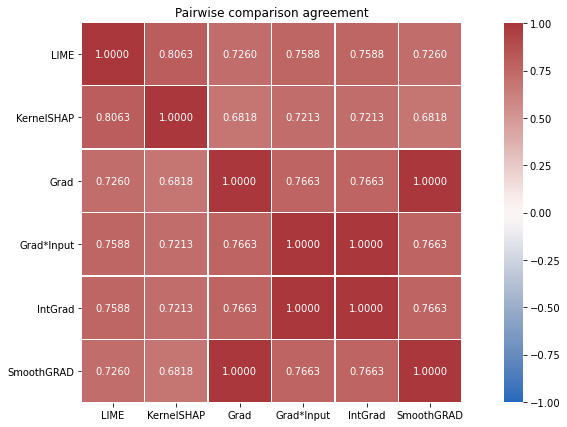

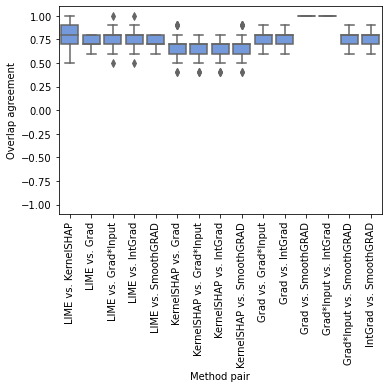

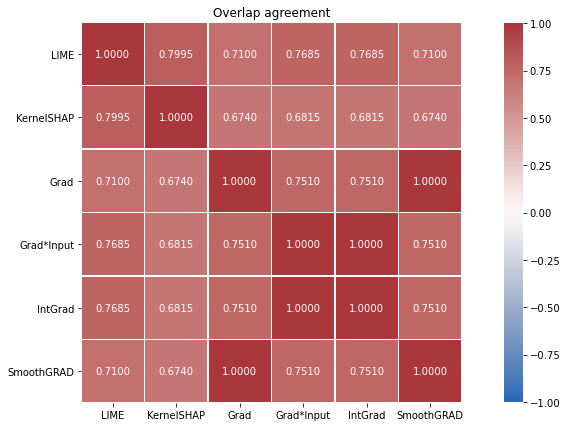

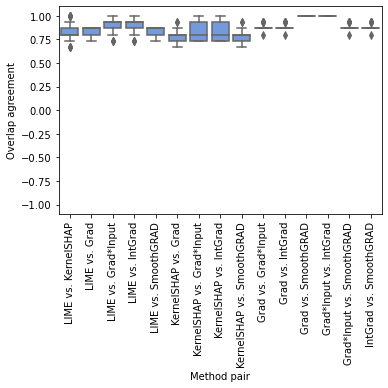

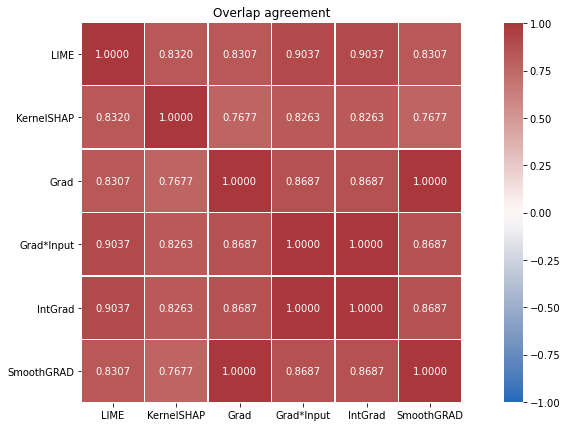

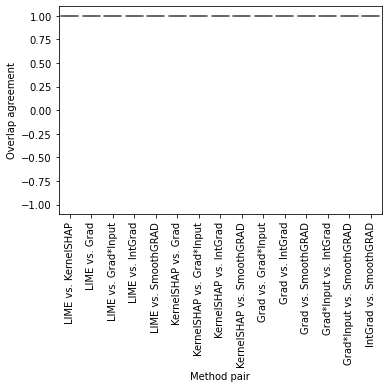

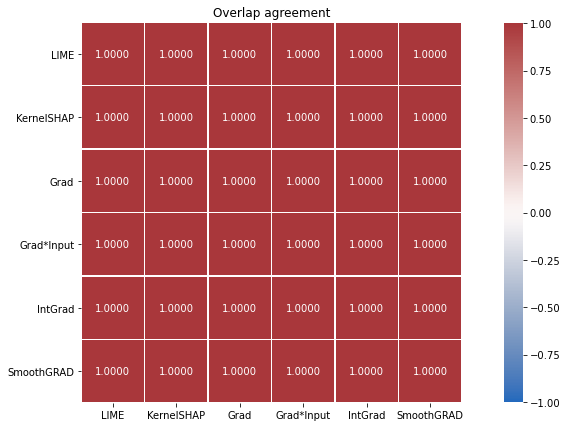

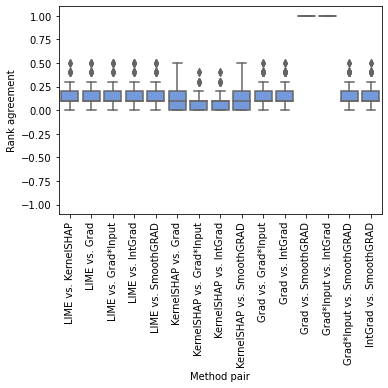

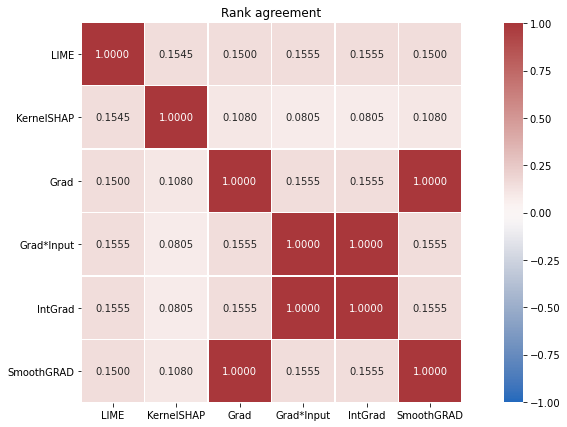

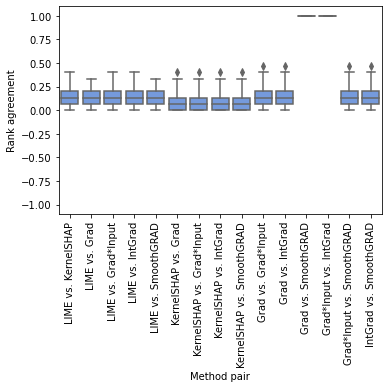

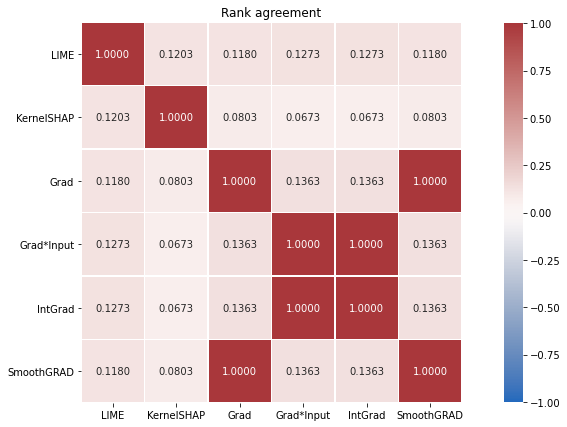

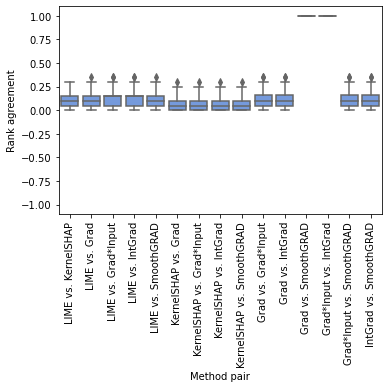

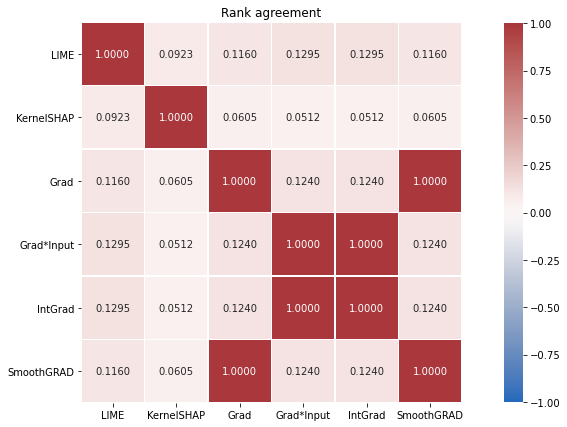

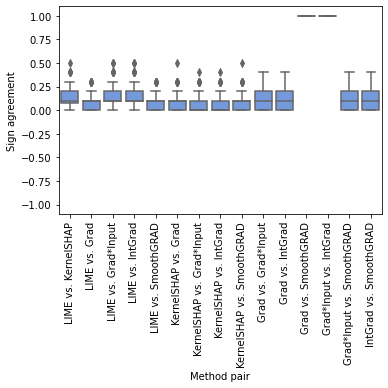

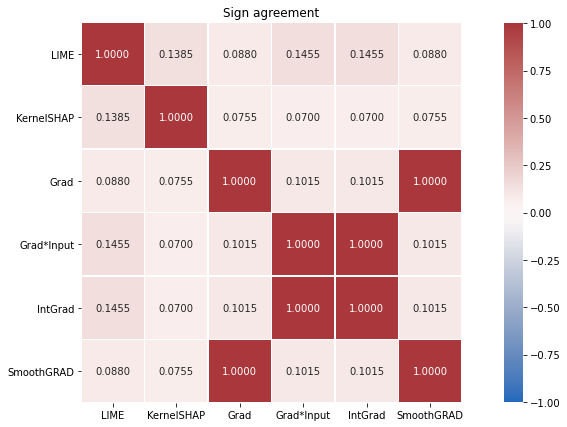

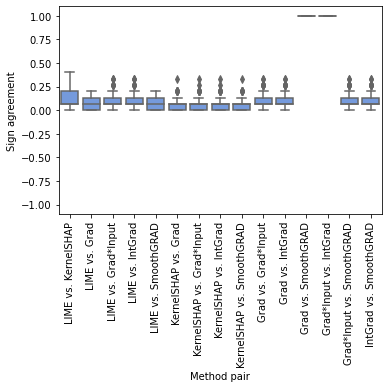

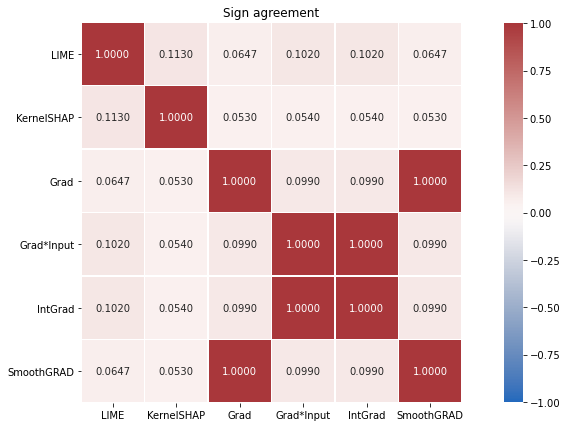

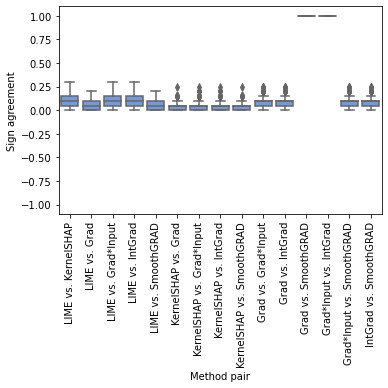

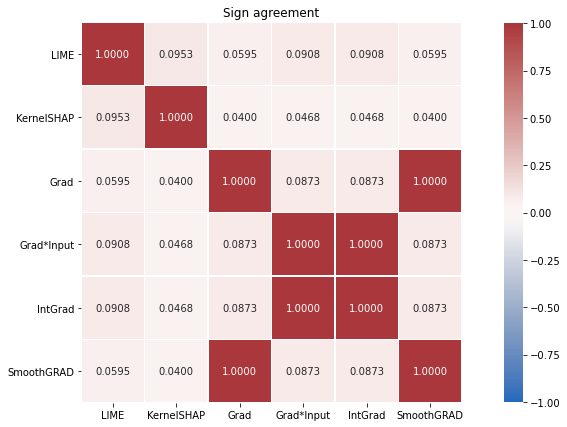

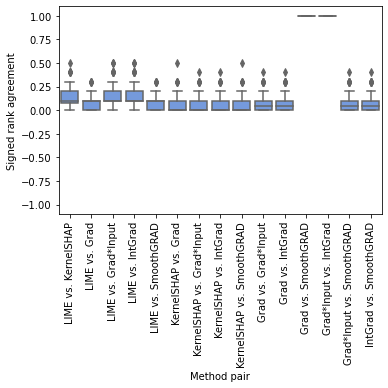

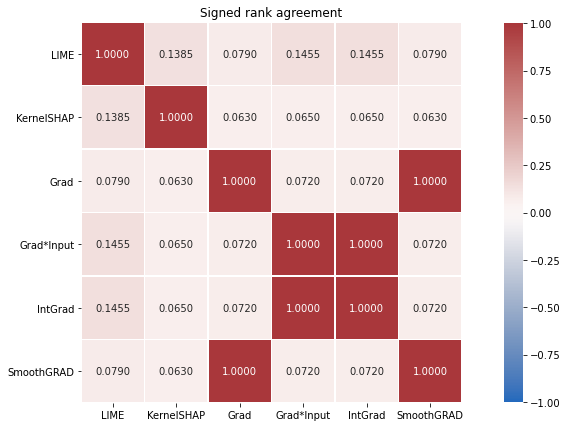

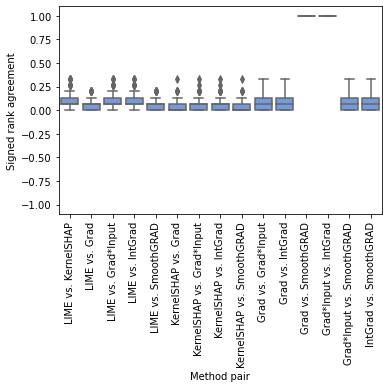

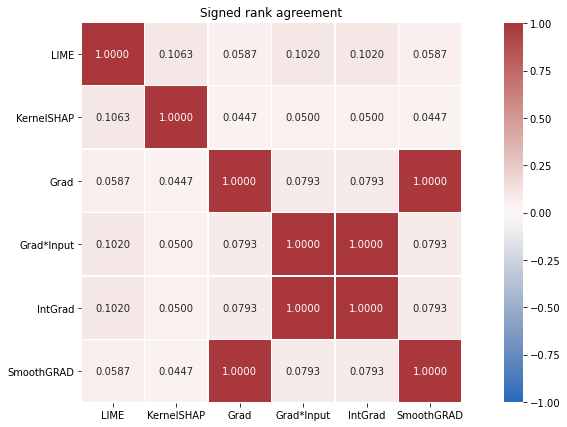

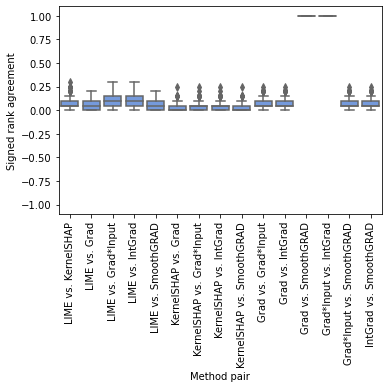

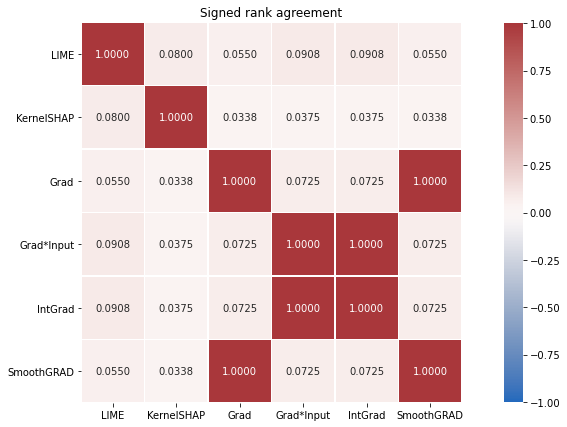

In [12]:
#logistic + nn models
expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP', 
                2: 'Grad',
                3: 'Grad*Input',
                4: 'IntGrad',
                5: 'SmoothGRAD'}

models_list = ['nn', 'nn_logistic']
metrics_list = ['rankcorr', 'pairwise', 'overlap', 'rank', 'sign', 'ranksign']
#ks_list = [1, 2, 3, 4, 5, 6, 7]
ks_list = [10, 15, 20]

for model in models_list:
    expl_methods_attrs = {0: attr_lime[model],
                          1: attr_kernelshap[model], 
                          2: attr_vanillagrad[model],
                          3: attr_gradtinput[model],
                          4: attr_integratedgrad[model],
                          5: attr_smoothgrad[model]}

    for metric in metrics_list:
        print(f'----------- calculating: {model}, {metric} -----------')
        if metric in ['overlap', 'rank', 'sign', 'ranksign']:
            for k in ks_list:
                print(f'k={k}')
                method_pairs_distr, method_pairs_avg = metric_analysis(expl_methods_names, expl_methods_attrs, k, f'figures/{model}', metric)
        else:
            k=0 #arbitrary: these metrics (rankcorr and pairwise) don't use k
            method_pairs_distr, method_pairs_avg = metric_analysis(expl_methods_names, expl_methods_attrs, k, f'figures/{model}', metric)    

----------- calculating: rf, rankcorr -----------
----------- calculating: rf, pairwise -----------
----------- calculating: rf, overlap -----------
k=10
k=15
k=20
----------- calculating: rf, rank -----------
k=10
k=15
k=20
----------- calculating: rf, sign -----------
k=10
k=15
k=20


<ipython-input-7-9eb37bbc705d>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 1, figsize=(5.5, 5.5))


----------- calculating: rf, ranksign -----------
k=10
k=15
k=20
----------- calculating: gb, rankcorr -----------
----------- calculating: gb, pairwise -----------
----------- calculating: gb, overlap -----------
k=10
k=15
k=20
----------- calculating: gb, rank -----------
k=10
k=15
k=20
----------- calculating: gb, sign -----------
k=10
k=15
k=20
----------- calculating: gb, ranksign -----------
k=10
k=15
k=20


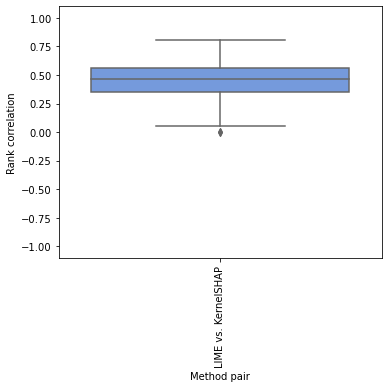

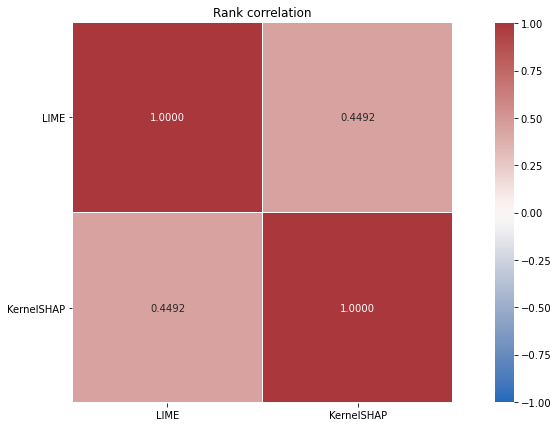

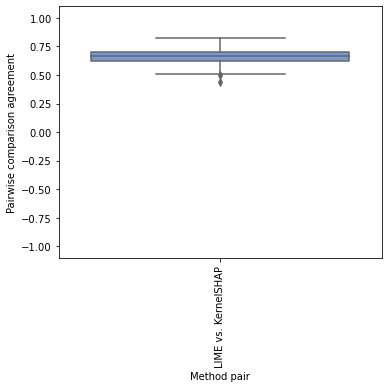

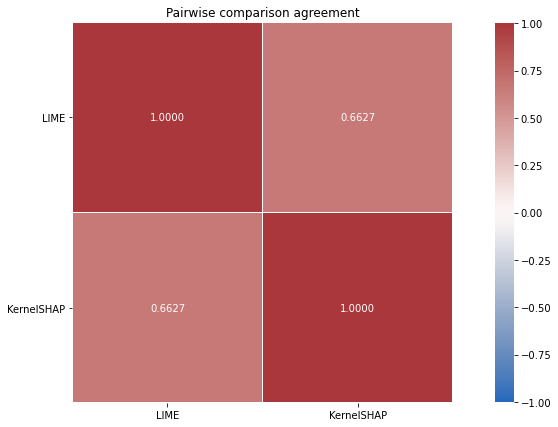

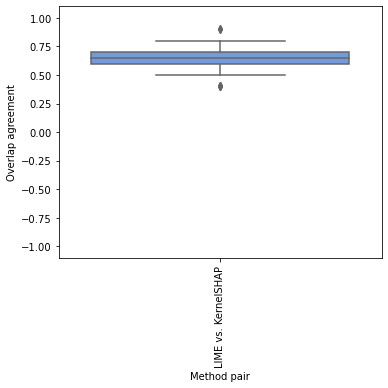

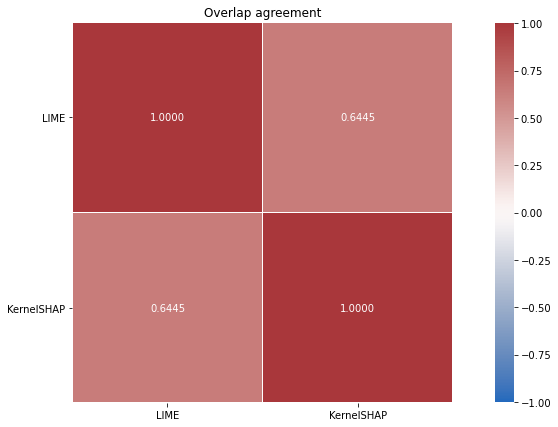

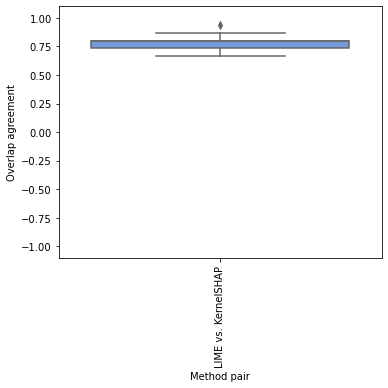

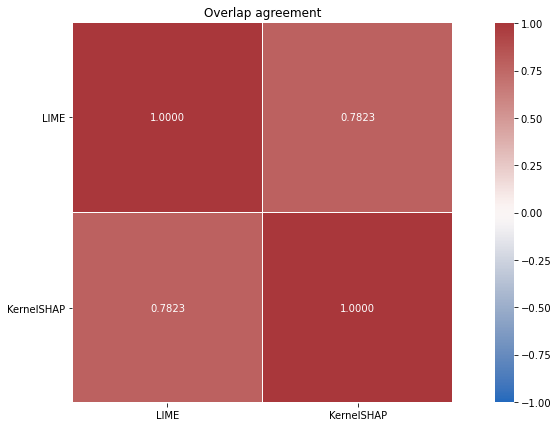

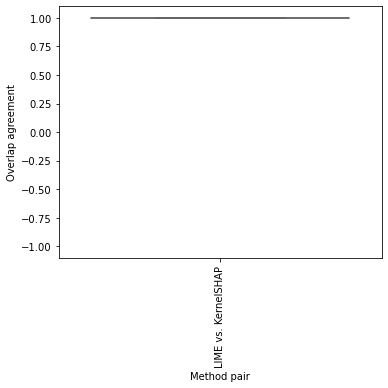

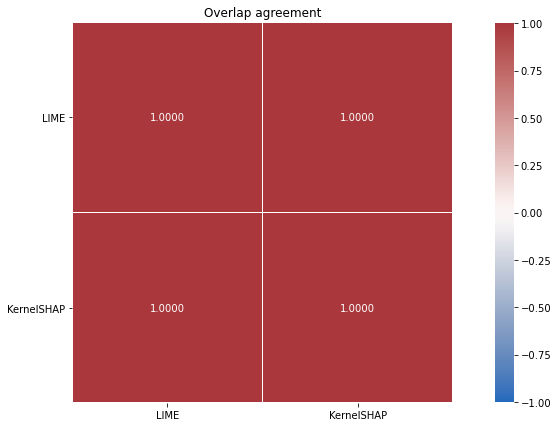

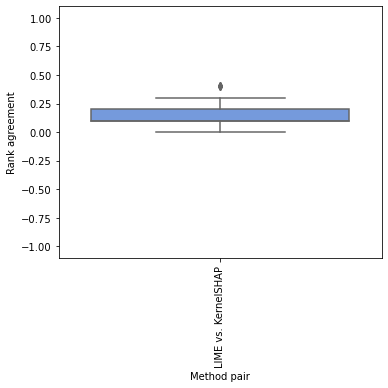

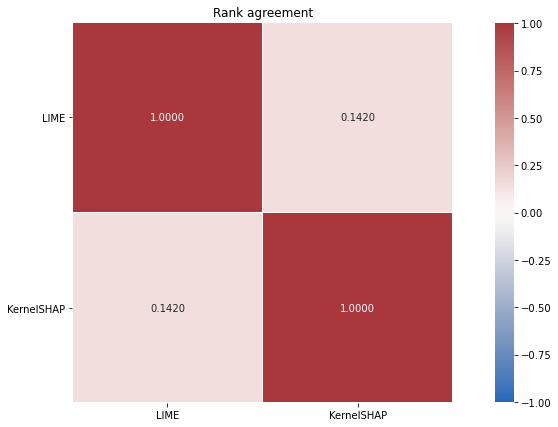

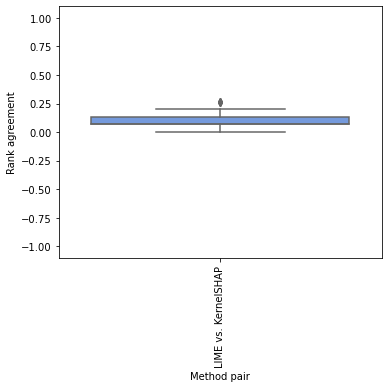

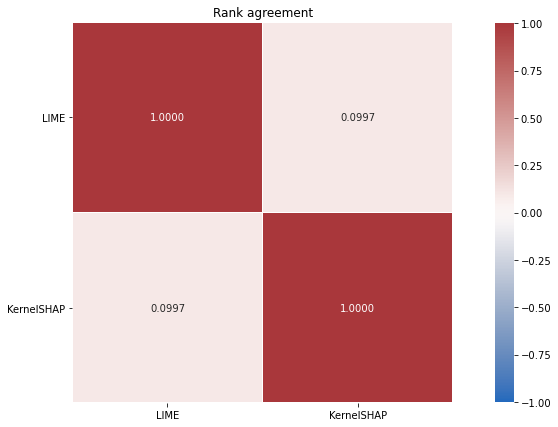

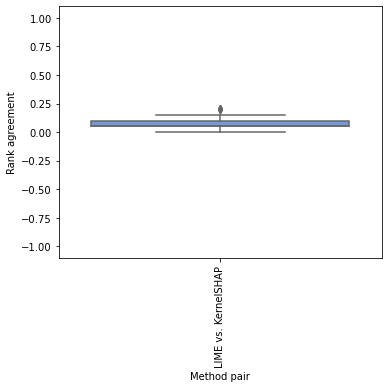

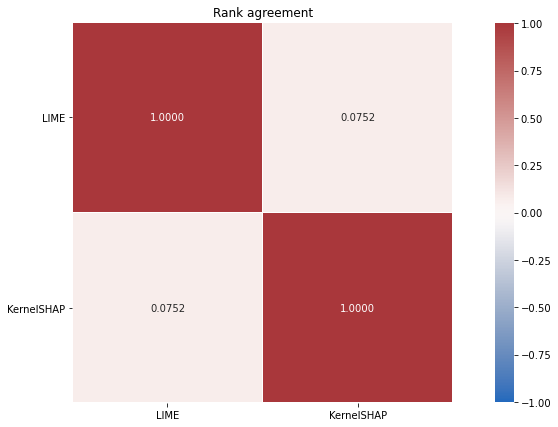

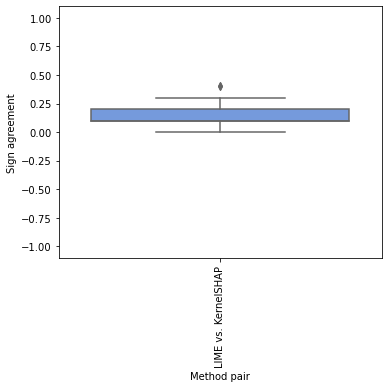

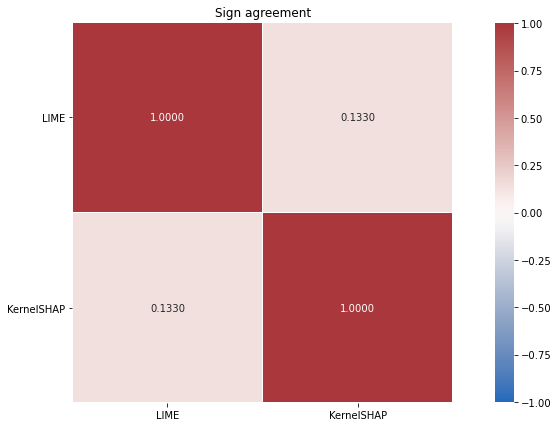

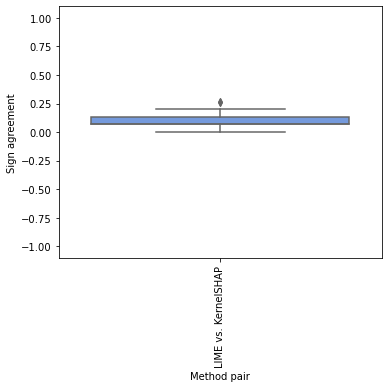

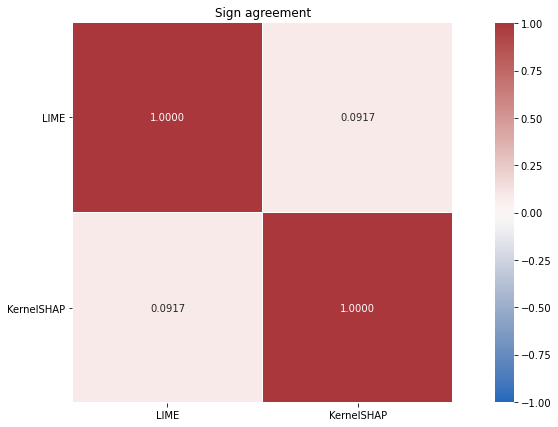

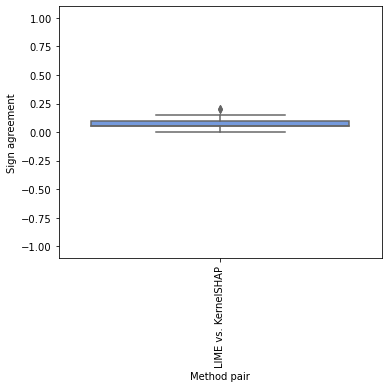

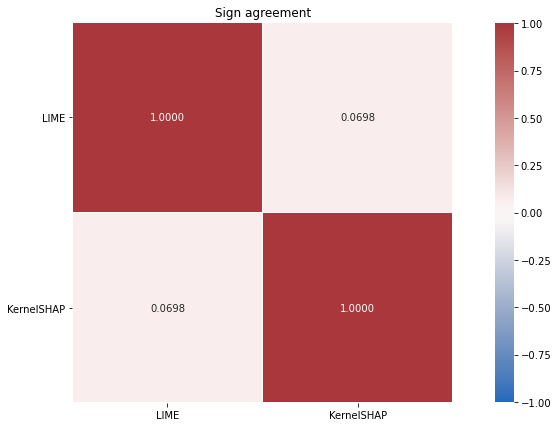

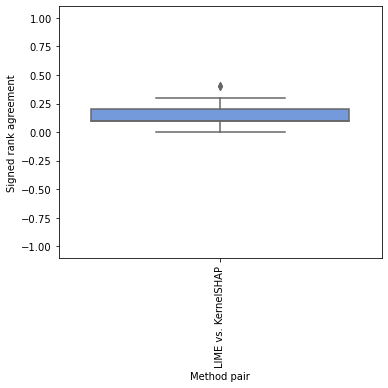

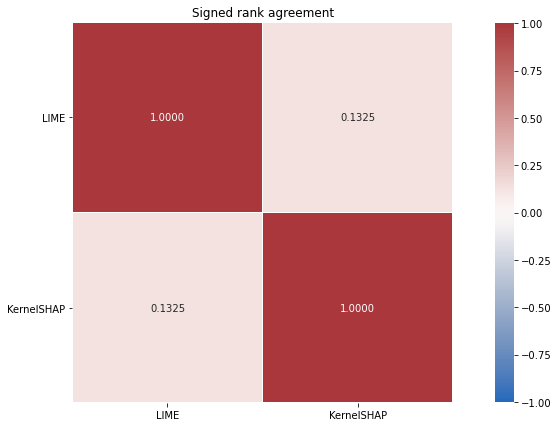

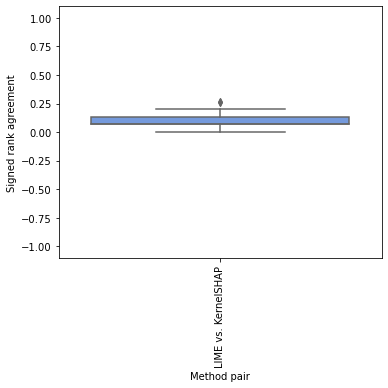

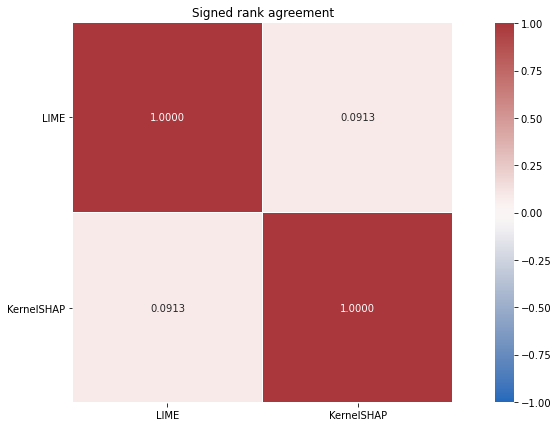

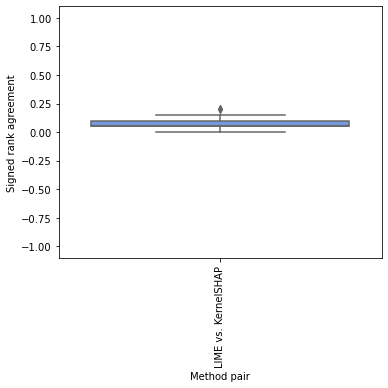

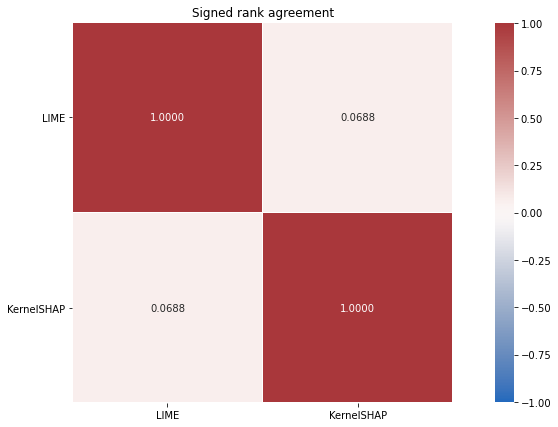

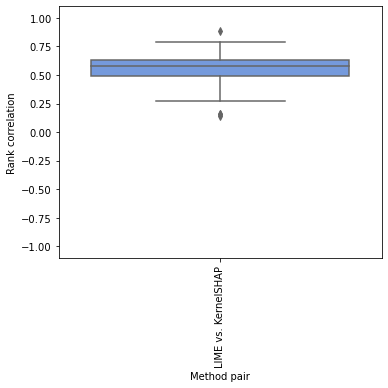

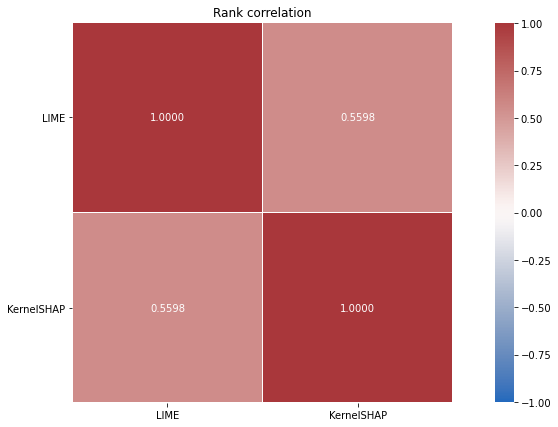

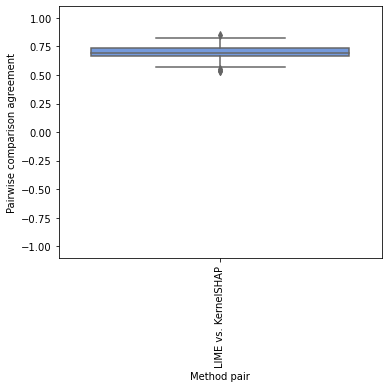

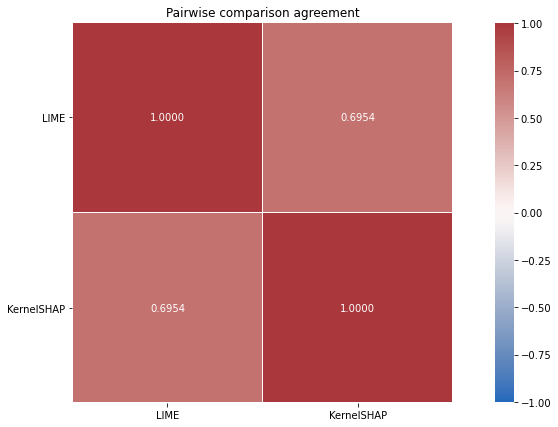

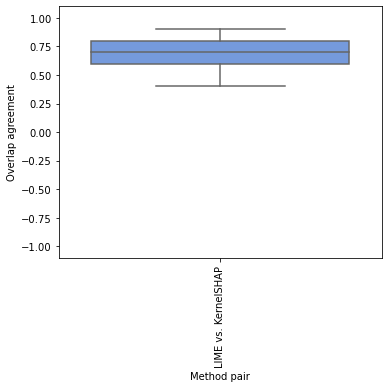

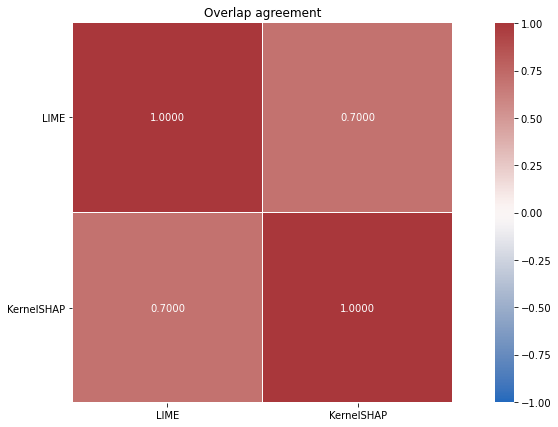

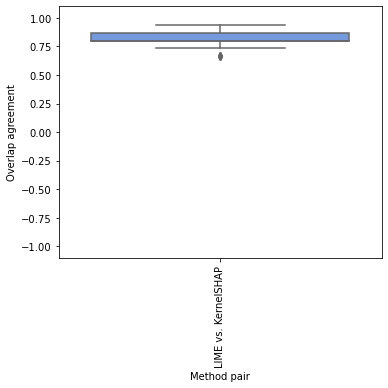

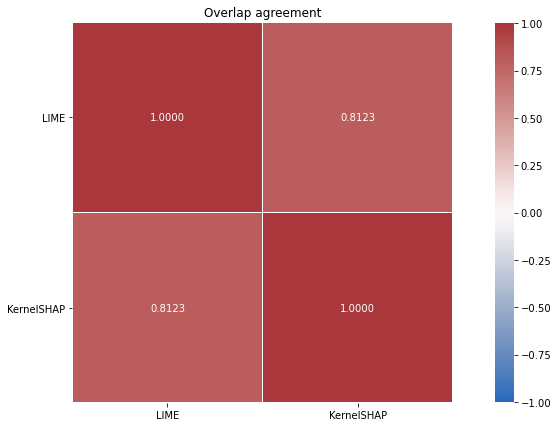

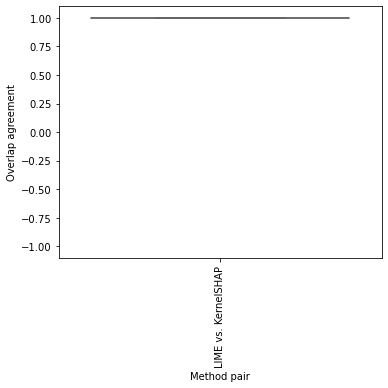

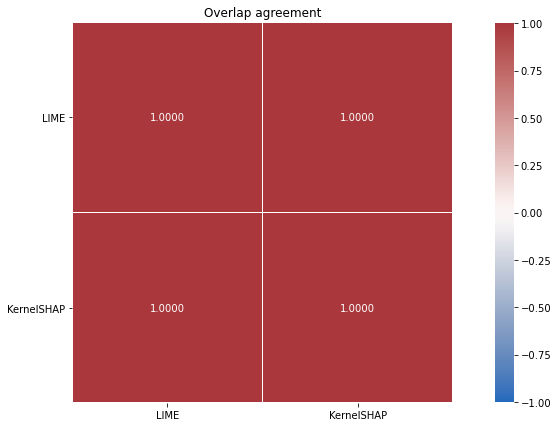

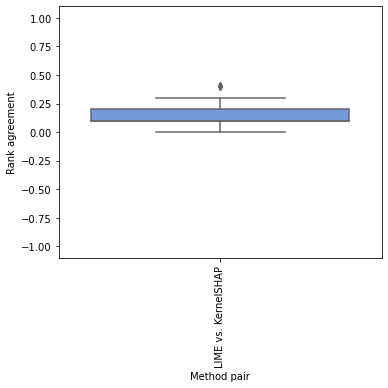

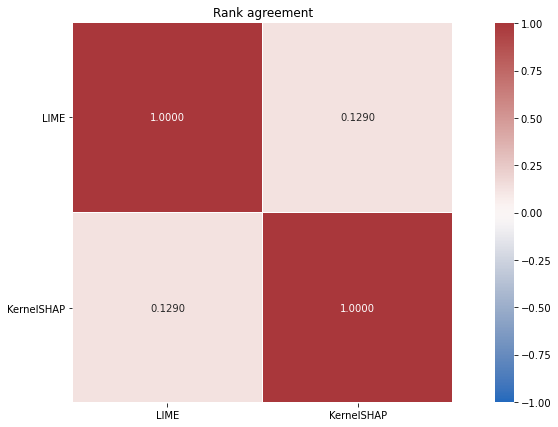

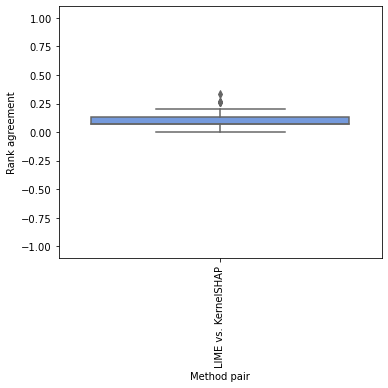

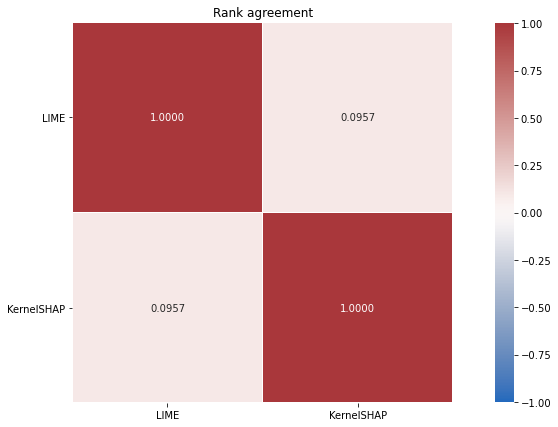

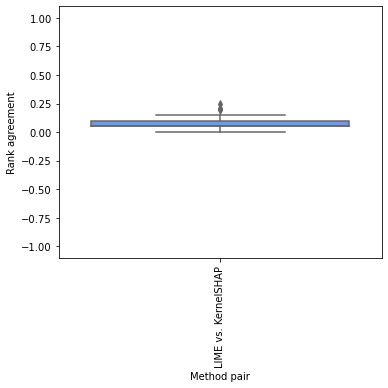

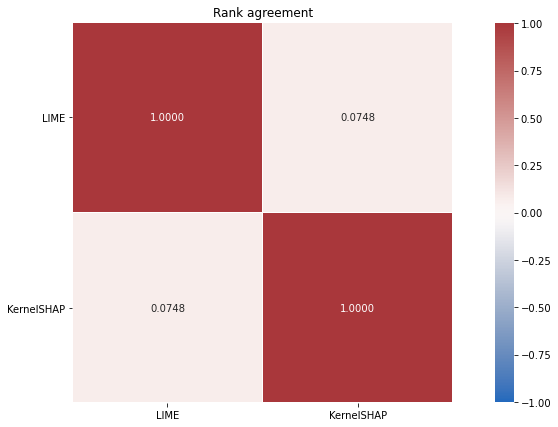

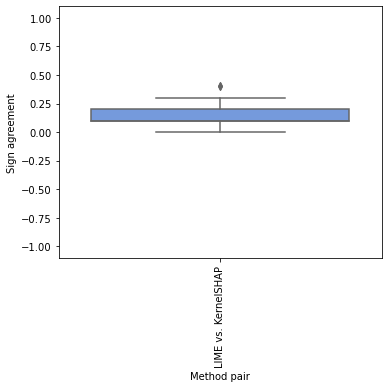

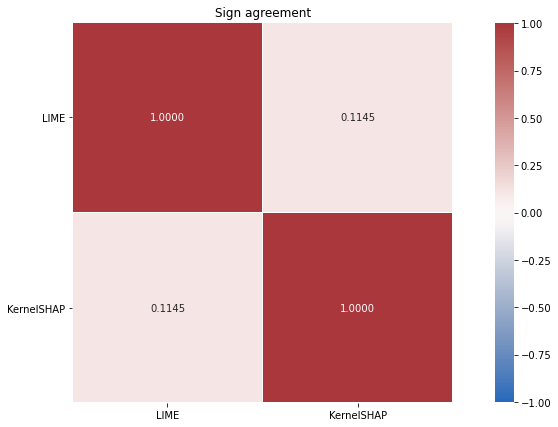

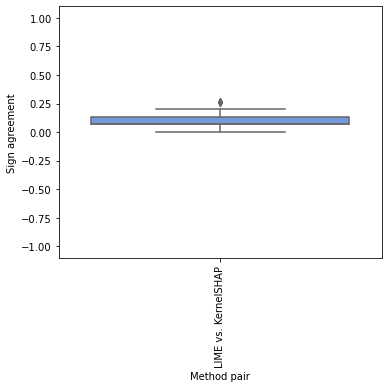

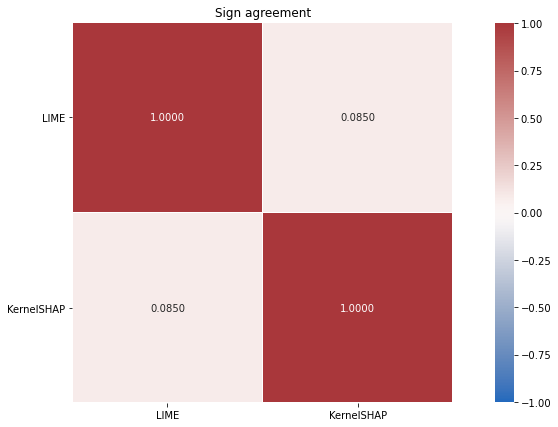

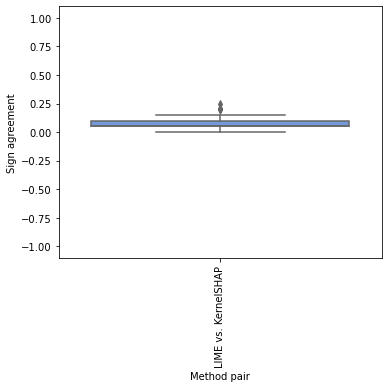

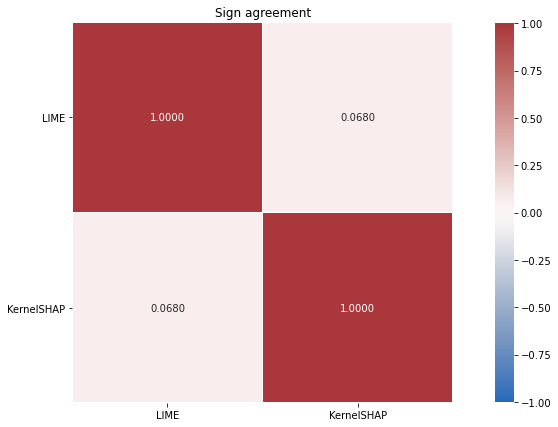

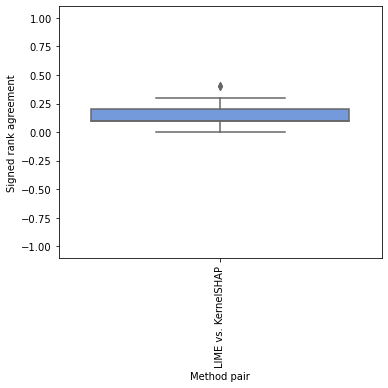

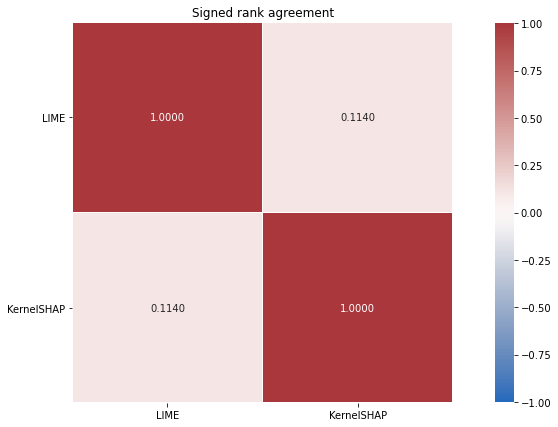

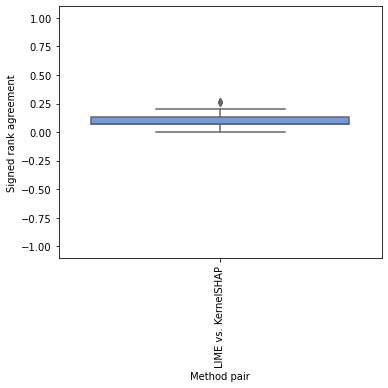

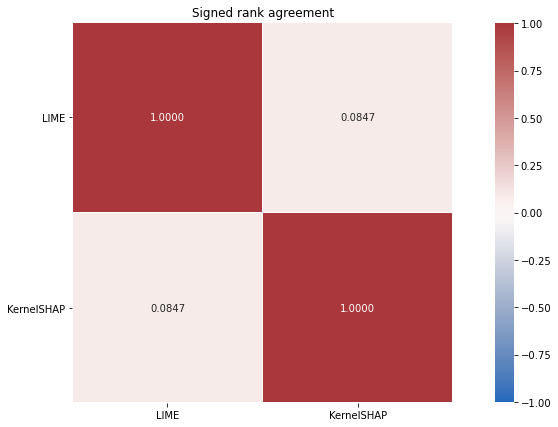

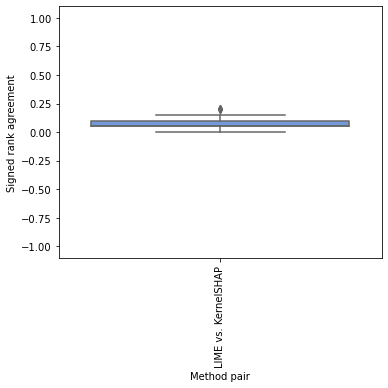

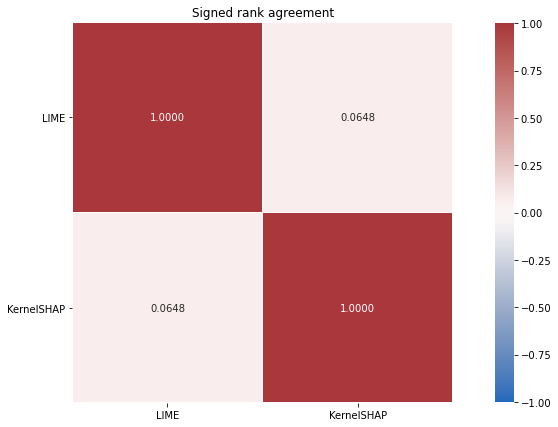

In [13]:
#rf + gb
expl_methods_names = {0: 'LIME',
                      1: 'KernelSHAP'}

models_list = ['rf', 'gb']
metrics_list = ['rankcorr', 'pairwise', 'overlap', 'rank', 'sign', 'ranksign']
#ks_list = [1, 2, 3, 4, 5, 6, 7]
ks_list = [10, 15, 20]

for model in models_list:
    expl_methods_attrs = {0: attr_lime[model],
                          1: attr_kernelshap[model]}

    for metric in metrics_list:
        print(f'----------- calculating: {model}, {metric} -----------')
        if metric in ['overlap', 'rank', 'sign', 'ranksign']:
            for k in ks_list:
                print(f'k={k}')
                method_pairs_distr, method_pairs_avg = metric_analysis(expl_methods_names, expl_methods_attrs, k, f'figures/{model}', metric_type=metric, labels=['LIME', 'KernelSHAP'])
        else:
            k=0 #arbitrary: these metrics (rankcorr and pairwise) don't use k
            method_pairs_distr, method_pairs_avg = metric_analysis(expl_methods_names, expl_methods_attrs, k, f'figures/{model}', metric_type=metric, labels=['LIME', 'KernelSHAP'])    
            